# CV Exercise 5: Image Segmentation Exercise

In this exercise we will build and train our own U-Net image segmentation architecture, in order to segment satellite images.

We will use the [DroneDeploy Segmentation Dataset](https://github.com/dronedeploy/dd-ml-segmentation-benchmark) of aerial photographs taken by drones, and segmentation labels for each scene. See that link for more information on the dataset.

For more cool datasets of satellite imagery that may be used for machine learning, see: [Awesome Satellite Imagery Datasets](https://github.com/chrieke/awesome-satellite-imagery-datasets)

Note: You are **recommended to use GPU acceleration** for this exercise.

## Part 1. Setting up data files

If you are working in Google Colab, you are **highly recommended** to download the data files to Google Drive, and then use the code below to mount your Google Drive within your Colab session and copy the data files to your session's directory.

**Questions:**

1. Download the attached data files and decompress the `.tar.gz` archive file. If you are working in Google Colab, you may use the code given below.

2. Use the code given below to load the label configuration and plot the colors that will be used for each label. Examine the values of `N_LABELS`, `LABEL_NAMES`, and `LABEL_COLORS`. What does each of these contain?

In [1]:
import json
import numpy as np
from matplotlib import pyplot as plt
from google.colab import drive
import os
import cv2
import matplotlib.pyplot as plt
import os
import glob
import collections
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [2]:
### CODE FOR QUESTION 1 ###
DATA_FN = 'satellite_data.tar.gz'
LABEL_CONFIG_FN = 'label_config.json'

In [3]:
### CODE FOR QUESTION 1 (if working in Google Colab) ###
### replace ... below with the correct directory ###
drive.mount('/content/drive')

MYDIR =  '/content/drive/MyDrive'

FULL_DATA_FN = f'{MYDIR}/{DATA_FN}'
FULL_CONFIG_FN = f'{MYDIR}/{LABEL_CONFIG_FN}'

! cp "{FULL_DATA_FN}" .
! cp "{FULL_CONFIG_FN}" .

! tar xzfv {DATA_FN}

A saída de streaming foi truncada nas últimas 5000 linhas.
satellite_data/train/masks/img/1553627230_APIGENERATED-000040.png
satellite_data/train/masks/img/1553627230_APIGENERATED-000091.png
satellite_data/train/masks/img/520947aa07_8FCB044F58OPENPIPELINE-000006.png
satellite_data/train/masks/img/1553541585_APIGENERATED-000088.png
satellite_data/train/masks/img/888432f840_80E7FD39EBINSPIRE-000441.png
satellite_data/train/masks/img/1553541487_APIGENERATED-000001.png
satellite_data/train/masks/img/f4dd768188_NOLANOPENPIPELINE-000061.png
satellite_data/train/masks/img/84410645db_8D20F02042OPENPIPELINE-000025.png
satellite_data/train/masks/img/3502e187b2_23071E4605OPENPIPELINE-000130.png
satellite_data/train/masks/img/130a76ebe1_68B40B480AOPENPIPELINE-000138.png
satellite_data/train/masks/img/b705d0cc9c_E5F5E0E316OPENPIPELINE-000030.png
satellite_data/train/masks/img/f9f43e5144_1DB9E6F68BINSPIRE-000136.png
satellite_data/train/masks/img/f9f43e5144_1DB9E6F68BINSPIRE-000104.png
satellite_dat

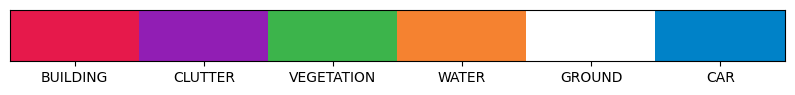

In [4]:
### CODE FOR QUESTION 2 ###
with open(LABEL_CONFIG_FN, 'r') as f:
  label_config = json.load(f)

N_LABELS = len(label_config)
LABEL_NAMES = sorted(label_config, key=lambda k: label_config[k]['index'])
LABEL_COLORS = np.array([label_config[n]['color'] for n in LABEL_NAMES])

plt.figure(figsize=(10, 10))
plt.imshow(LABEL_COLORS[None], aspect=0.4)
plt.xticks(range(N_LABELS), LABEL_NAMES)
plt.yticks([])
plt.show()

## Part 2. EDA

**Questions:**

3. Examine the contents of `satellite_data/`. How many samples are in the train set? How many samples are in the validation set?
4. Plot at least one image from the train set. Note: If using OpenCV, make sure you converted from BGR to RGB before plotting.
5. Use the code given below to plot the target mask(s) for the image(s) that you plotted in question 4. `fn_mask` should be the filename of the mask file that you would like to plot. Note: Pick an image in 4 that has a mask with at least two labels.
6. Compare the labels in the mask(s) to the values from question 2. Do the labels make sense?
7. The dataset may be considered unbalanced because some labels are much more common than others in masks. Using `collections.Counter`, count the number of pixels with each label value in the train dataset. Print out the percentage of mask pixels in which label occurs.

  Hints:
  * You are recommended to use `glob` and `tqdm` to iterate through all `.png` files in `train/masks/`. It should take less than 2 minutes to iterate through all of them.
  * Although the mask files are `.png` files with three channels, you only need to use one channel (the data is duplicated across channels).
  * You may check the total number of pixels in the train set as a sanity check. The value you get should be about 500M.

8. What would be the baseline (per-pixel) accuracy of a segmentation model that just always predicted the majority class?

In [5]:
#3
print(f"train samples:{len(os.listdir('/content/satellite_data/train/images/img'))}")
print(f"valid samples:{len(os.listdir('/content/satellite_data/valid/images/img'))}")

train samples:5843
valid samples:1045


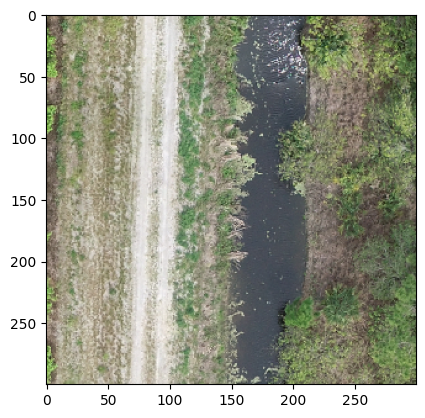

In [6]:
#4
image_path = os.path.join('/content/satellite_data/train/images/img', os.listdir('/content/satellite_data/train/images/img')[0])

image = cv2.imread(image_path)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.show()

In [7]:
fn_mask = os.path.join('/content/satellite_data/train/masks/img', os.listdir('/content/satellite_data/train/masks/img')[0])

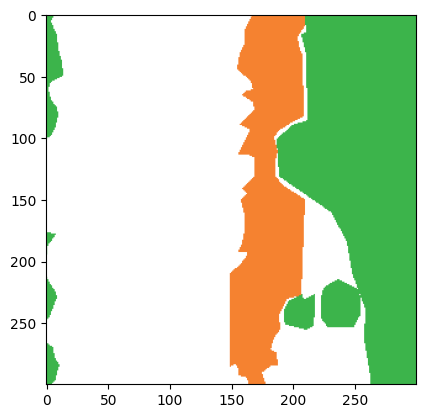

In [8]:
### CODE FOR QUESTION 5 ###
mask_labels = cv2.imread(fn_mask)[..., 0]
mask = LABEL_COLORS[mask_labels]
plt.imshow(mask)

**EX6**

Yes the labels make sense, it labels has ground, water and vegetation correctly

In [9]:
train_masks_folder = '/content/satellite_data/train/masks/img'
mask_files = glob.glob(os.path.join(train_masks_folder, '*.png'))

label_counter = collections.Counter()
total_pixels = 0

for mask_file in tqdm(mask_files, desc="Processing masks"):
    mask_image = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
    label_counter.update(mask_image.flatten())
    total_pixels += mask_image.size


print("Percentage of mask pixels for each label:")
for label_index, count in label_counter.items():
    label_name = LABEL_NAMES[label_index]
    percentage = (count / total_pixels) * 100
    print(f"Label {label_name}: {percentage:.2f}%")


Processing masks: 100%|██████████| 5843/5843 [01:24<00:00, 69.23it/s]

Percentage of mask pixels for each label:
Label VEGETATION: 26.27%
Label GROUND: 64.29%
Label WATER: 2.95%
Label CLUTTER: 2.31%
Label BUILDING: 3.84%
Label CAR: 0.33%


**EX8**

The baseline would be predicting Label GROUND for an accuracy of 64.29%

## Part 3. Creating Dataset generators

As is common in CV tasks, we do not want to load our entire dataset into memory at once. It will be more efficient to create generators that dynamically load image data when needed for training our model.

We will do this by creating Keras `ImageDataGenerator` instances.

**Questions:**
9. Using `ImageDataGenerator` and its method `flow_from_directory()`, create generators for the image and mask files. Use the code given below as a starting point, and follows these instructions:

  * You should create four generator objects: `image_gen_train`, `image_gen_valid`, `mask_gen_train`, and `mask_gen_valid`.
  * Required parameters:
    * `class_mode=None`
    * `batch_size=batch_size` (generators return batches of images)
    * `target_size=target_size` (we make images smaller so our model can train faster)
    * `seed=seed`
  * For `mask_gen_train` and `mask_gen_valid`: Because we only need one channel from the masks, wrap your generators in `(x[..., 0] for x in generator)`.
10. Use the code below to create generators for train and validation data (images and masks together).
11. Using `next(train_gen)` and the code for question 5, sample and plot an image and corresponding mask from the train set. Make sure that the image and mask really correspond to each other.
12. Why did we need to pass `seed=seed` when creating each generator?

In [10]:
### CODE FOR QUESTION 9 ###
#batch_size = 16
#seed = 42
#target_size=(128, 128)

#from tensorflow.keras.preprocessing.image import ImageDataGenerator

#image_datagen = ImageDataGenerator(rescale=1./255)
#image_datagen_valid = ImageDataGenerator(rescale=1./255)
#mask_datagen = ImageDataGenerator()
#mask_datagen_valid = ImageDataGenerator()

batch_size = 16
seed = 42
target_size = (128, 128)

image_datagen = ImageDataGenerator(rescale=1./255)
image_gen_train = image_datagen.flow_from_directory(
    '/content/satellite_data/train/images',
    class_mode=None,
    batch_size=batch_size,
    target_size=target_size,
    seed=seed
)

image_datagen_valid = ImageDataGenerator(rescale=1./255)
image_gen_valid = image_datagen_valid.flow_from_directory(
    '/content/satellite_data/valid/images',
    class_mode=None,
    batch_size=batch_size,
    target_size=target_size,
    seed=seed
)

mask_datagen = ImageDataGenerator()
mask_gen_train = mask_datagen.flow_from_directory(
    '/content/satellite_data/train/masks',
    class_mode=None,
    batch_size=batch_size,
    target_size=target_size,
    seed=seed
)

mask_datagen_valid = ImageDataGenerator()
mask_gen_valid = mask_datagen_valid.flow_from_directory(
    '/content/satellite_data/valid/masks',
    class_mode=None,
    batch_size=batch_size,
    target_size=target_size,
    seed=seed
)

mask_gen_train = (x[..., 0] for x in mask_gen_train)
mask_gen_valid = (x[..., 0] for x in mask_gen_valid)


Found 5843 images belonging to 1 classes.
Found 1045 images belonging to 1 classes.
Found 5843 images belonging to 1 classes.
Found 1045 images belonging to 1 classes.


In [11]:
### CODE FOR 10 ###
train_gen = zip(image_gen_train, mask_gen_train)
valid_gen = zip(image_gen_valid, mask_gen_valid)

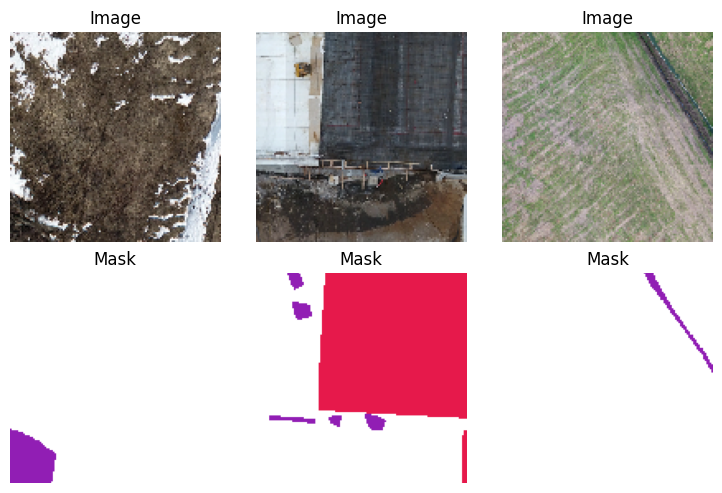

In [24]:
#11
sample_images, sample_masks = next(train_gen)

plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(2, 4, i + 1)
    plt.imshow(sample_images[i])
    plt.title('Image')
    plt.axis('off')

    plt.subplot(2, 4, i + 5)
    colored_mask = np.zeros(sample_masks[i].shape + (3,), dtype=np.uint8)
    for j in range(N_LABELS):
        colored_mask[sample_masks[i] == j] = LABEL_COLORS[j]
    plt.imshow(colored_mask)
    plt.title('Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()


**EX12**

usinfg seed=seed to each generator ensures that all four generators use the same random seed, which means they will produce the same results when performing any random operations. This consistency is important, especially during training/validation, as we want to ensure that the data and labels are synchronized.

## Part 4. Creating the U-Net Model

In this section we will create the deep U-Net model that will learn how to segment images.

Please reference the original paper when answering the relevant questions: [Ronneberger et al. (2015) U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf), especially figure 1.

**Questions:**
13. The implementation below is incomplete. Fill in the blanks given by ... with the correct values, referencing the paper. Hint: They should be powers of two. Note: We are using inputs of shape `(128, 128, 3)` rather than `(572, 572, 1)` as in the paper, but we will still use the same sizes for most non-input layers.
14. What difference(s) do you see between the architecture given in the paper (figure 1) and our implementation?
15. Briefly (1-2 sentences) explain why we used He Initialization for convolutional layers (see p. 5 in the paper). Note: For more information on the default Glorot/Xavier initialization vs. He initialization, see [this post by Mustafa Murat (2019)](https://mmuratarat.github.io/2019-02-25/xavier-glorot-he-weight-init).
16. Verify that the model has input shape `(None, 128, 128, 3)` and output shape `(None, 128, 128, 6)`. Explain what these shapes mean.
17. Verify that the model has `31,035,184` parameters (all trainable).
18. Plot the model's architecture with `tf.keras.utils.plot_model(..., show_shapes=True)`. Can you see why it is called a U-Net? (compare to figure 1 in the paper)

In [13]:
### CODE FOR 13 ###

INPUT_SIZE = (128, 128, 3)
DROPOUT_P = 0.5



inputs=Input(INPUT_SIZE)

conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
out4 = Dropout(DROPOUT_P)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(out4)

conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
out5 = Dropout(DROPOUT_P)(conv5)

up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(out5))
merge6 = concatenate([out4, up6], axis=3)
conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
merge7 = concatenate([conv3, up7], axis=3)
conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
merge8 = concatenate([conv2, up8], axis=3)
conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
merge9 = concatenate([conv1, up9], axis=3)
conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv9 = Conv2D(N_LABELS, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
conv10 = Conv2D(N_LABELS, 1, activation='softmax')(conv9)

model = Model(inputs=inputs, outputs=conv10)

**EX14**

some differences:\
Input size: The paper uses an input size of (572, 572, 1) while our implementation uses (128, 128, 3)

Dropout: The paper does not mention the use of dropout, while our implementation includes dropout layers after certain convolutional layers with a dropout probability of 0.5.

**EX15**

According to the Mustafa Murat ARAT post we use He initialization for convolutional layers because it is specifically designed for deep networks and helps to prevent vanishing or exploding gradients during training by initializing weights according to the size of the previous layer's activations.

In [14]:
#16
model.input_shape, model.output_shape

((None, 128, 128, 3), (None, 128, 128, 6))

Input shape: (None, 128, 128, 3)\
(None): Represents the batch size, which can vary during training or inference.\
(128, 128, 3): Represents the dimensions of each input image, where 128x128 is the height and width, and 3 is the number of channels (RGB).


Output shape: (None, 128, 128, 6)\
(None): Represents the batch size, which can vary during training or inference.\
(128, 128, 6): Represents the dimensions of each output prediction, where 128x128 is the height and width, and 6 is the number of output channels (corresponding to the number of labels color of json).

In [15]:
#17
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

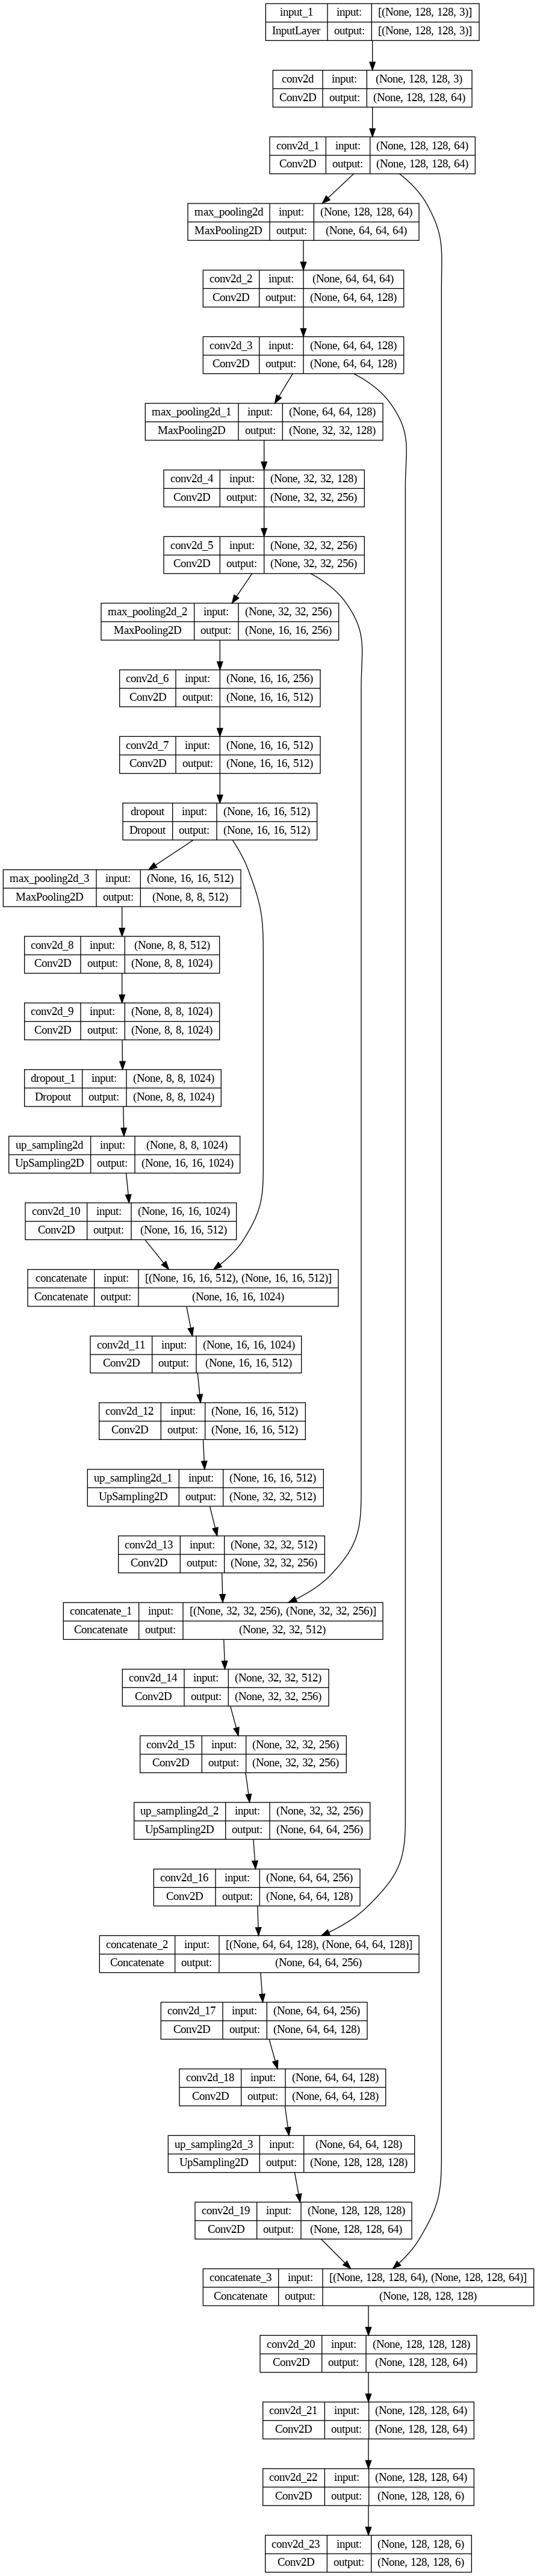

In [16]:
#18
plot_model(model, show_shapes=True)

## Part 5. Training the Model

Now we are ready to train our U-Net model on the train data.

**Questions:**
19. Compile the model with Adam optimizer (default learning rate of 1e-3), sparse categorical cross-entropy loss, and accuracy as a metric.
20. Fit your model on the training data using `train_gen`, and use `validation_data=valid_gen` so that validation loss and accuracy will be calculated after each epoch. Instructions:
  * Because the data is given as generators rather than all being stored in memory at once, we must set `steps_per_epoch=` and `validation_steps=` so TensorFlow knows how many batches to evaluate for each epoch.
  * `steps_per_epoch`: Use the number of batches in the training data (use your answer from 3 and the value of `batch_size` to calculate this).
  * `validation_steps`: Use whatever value you would like. Consider your answer from 3 and the value of `batch_size`.
  * Use early stopping to determine the number of epochs.
  
  You will probably be able to achieve validation loss `< 0.82` in less than 30 minutes, using GPU acceleration.

21. What is the best validation accuracy of your model? How does it compare to your answer to question 8?

In [17]:
#19
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
#20
steps_per_epoch = len(image_gen_train) // batch_size

validation_steps = len(image_gen_valid) // batch_size

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='/content/model_epoch_{epoch:02d}.h5', save_freq='epoch')

history = model.fit(train_gen,
                    steps_per_epoch=len(image_gen_train),
                    validation_data=valid_gen,
                    validation_steps=len(image_gen_valid),
                    epochs=100,
                    callbacks=[early_stopping, checkpoint])


Epoch 1/100
366/366 [==============================] - ETA: 0s - loss: 1.6755 - accuracy: 0.6443

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


366/366 [==============================] - 158s 357ms/step - loss: 1.6755 - accuracy: 0.6443 - val_loss: 1.0981 - val_accuracy: 0.7017
Epoch 2/100
366/366 [==============================] - 123s 336ms/step - loss: 0.9453 - accuracy: 0.6904 - val_loss: 0.8772 - val_accuracy: 0.7022
Epoch 3/100
366/366 [==============================] - 118s 323ms/step - loss: 0.7876 - accuracy: 0.7303 - val_loss: 0.9278 - val_accuracy: 0.7146
Epoch 4/100
366/366 [==============================] - 122s 334ms/step - loss: 0.7408 - accuracy: 0.7483 - val_loss: 0.9286 - val_accuracy: 0.6716
Epoch 5/100
366/366 [==============================] - 117s 319ms/step - loss: 0.7291 - accuracy: 0.7456 - val_loss: 0.8219 - val_accuracy: 0.7083
Epoch 6/100
366/366 [==============================] - 120s 329ms/step - loss: 0.6866 - accuracy: 0.7545 - val_loss: 0.8214 - val_accuracy: 0.7245
Epoch 7/100
366/366 [==============================] - 116s 317ms/step - loss: 0.6549 - accuracy: 0.7619 - val_loss: 0.9286 - val_

In [19]:
#22
best_val_accuracy = max(history.history['val_accuracy'])
print("Best validation accuracy:", best_val_accuracy)

Best validation accuracy: 0.7245327830314636


It has around 8% more accuracy than the baseline by predicting the majority.

## Part 6. Evaluating results

**Questions:**

22. Plot at least one image from the validation set, its true mask, and the predicted mask of your model.

23. Looking at some examples of predicted vs. true masks, what labels does it looks like your model is better at predicting? Which are more difficult for the model to predict?

24. (BONUS) Make a confusion matrix of your model's predicted labels vs. the true labels of each pixel in the validation dataset. Compare it to your answer to the previous question.

1/1 [==============================] - 0s 22ms/step


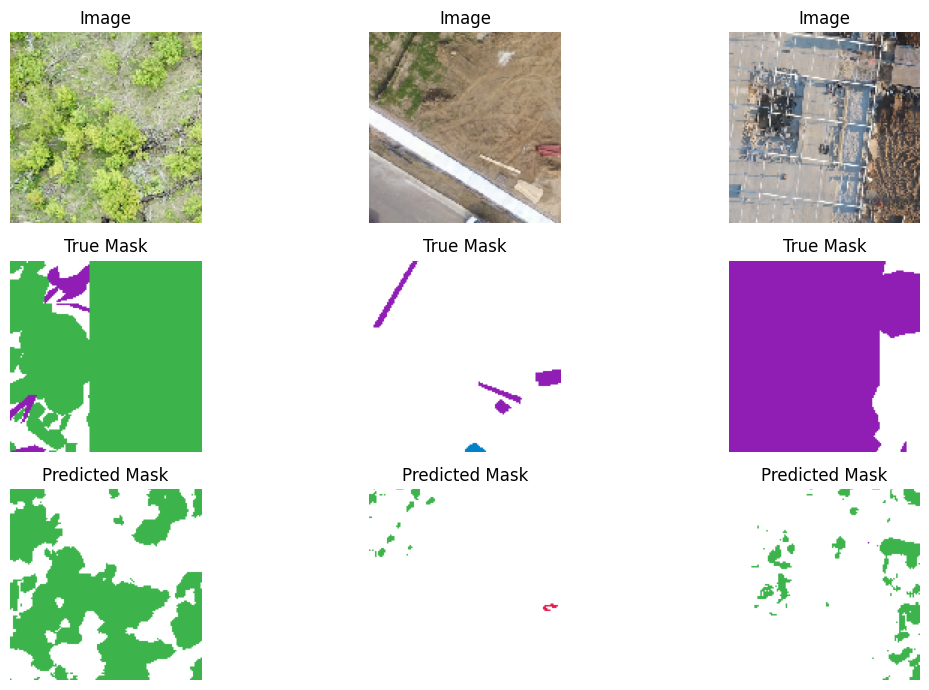

In [26]:
sample_images, sample_masks = next(valid_gen)

predicted_masks = model.predict(sample_images)

plt.figure(figsize=(15, 7))
for i in range(3):
    plt.subplot(3, 4, i + 1)
    plt.imshow(sample_images[i])
    plt.title('Image')
    plt.axis('off')

for i in range(3):
    plt.subplot(3, 4, i + 5)
    colored_true_mask = np.zeros(sample_masks[i].shape + (3,), dtype=np.uint8)
    for j in range(N_LABELS):
        colored_true_mask[sample_masks[i] == j] = LABEL_COLORS[j]
    plt.imshow(colored_true_mask)
    plt.title('True Mask')
    plt.axis('off')

for i in range(3):
    plt.subplot(3, 4, i + 9)
    reshaped_pred_mask = np.zeros(sample_images[i].shape, dtype=np.uint8)
    for j in range(N_LABELS):
        reshaped_pred_mask[predicted_masks[i].argmax(axis=-1) == j] = LABEL_COLORS[j]
    plt.imshow(reshaped_pred_mask)
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()

The predicted mask does not seems to be  accurate.